# EDA 2 - Time of Read Data

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('..'))

from tools.data_tfr import TFR
from tools.mask import plotgen
from tools.decode_raw import decode_img_seg

In [2]:
reader = TFR()

seg_train_gen_params = {
    'csv_path': '../data/train.csv',
    'train_path': '../data/train_images',
    'height': 256,
    'width': 1600, 
    'col': False,
    'sep':'[_,]'
}

gen = reader.seg_train_gen(**seg_train_gen_params)
count = reader.count('../data/train_images')

In [ ]:
for i in tqdm(gen):
    pass

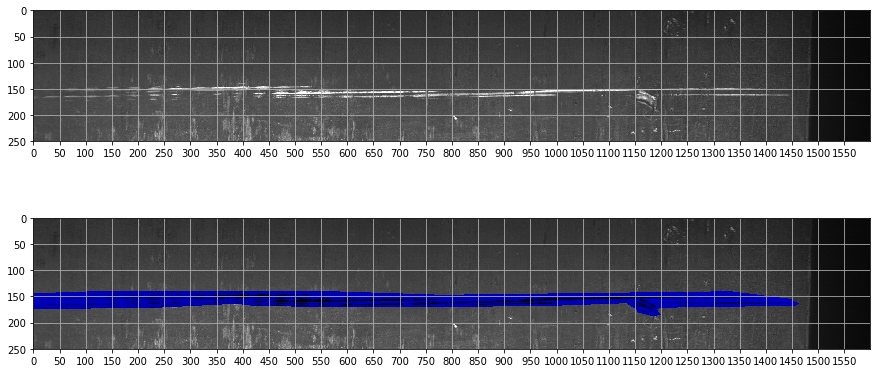

In [4]:
i = 0
n = 222

while True:
    example = next(gen)
    if i == n:
        plotgen(example['label'], example['img'], [15, 7])
        break
    else:
        i += 1

In [ ]:
feature_dict = {'img': 'bytes', 'label': 'bytes'}

write_tfr_params = {
    'data_generator': gen,
    'count': count,
    'tfrpath': 'train',
    'feature_dict': feature_dict,
    'shards': 10,
    'compression': 'GZIP', 'c_level': 1}

reader.write_tfr(**write_tfr_params)

In [ ]:
files = tf.train.match_filenames_once(os.path.join('..', 'tmp', 'TFRecords', 'test', '*.tfrecord'))

with tf.Session() as sess:
    # tf.local_variables_initializer().run()
    sess.run(tf.local_variables_initializer())
    print(sess.run(files))

In [ ]:
read_params = {
    'feature_dict': {'img': 'bytes', 'label': 'bytes'},
    'tfr_path': os.path.join('..', 'tmp', 'TFRecords', 'train_1', '*'),
    'decode_raw': decode_img_seg,
    'shuffle_buffer': 1000,
    'num_valid': 2000,
    'compression': 'GZIP'}

dr = DataReader()
dr.readtfrecorde(**read_params)

In [ ]:
# test tfrecords
dir_path = os.path.join('..', 'tmp', 'TFRecords', f'test')
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
os.makedirs(dir_path)

with tf.io.TFRecordWriter('../tmp/TFRecords/test/1.tfrecord') as writer:
    for i in range(100):
        img = np.zeros((4, 4)).astype('uint8').tostring()
        feature = {'img': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))}
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())

In [ ]:
# test datasets
def parse(raw):
    features = {'img': tf.io.FixedLenFeature([], tf.string)}
    raw = tf.parse_single_example(raw, features=features)
    img = tf.decode_raw(raw['img'], tf.uint8)
    return img 

tfr_path = os.path.join('..', 'tmp', 'TFRecords', 'train', '*.tfrecord')
files = tf.io.match_filenames_once(tfr_path)
dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
dataset = dataset.map(parse)